## 1. Imports and Paths

In [1]:
# Playing with labeled image data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from helper_functions import HarrisKeypointDetector, SimpleFeatureDescriptor, \
    ORB_SIFT_FeatureDescriptor, extract_color_moments, hu_moments

In [2]:
# Define directories
base_dir = '/Users/jetcalz07/Desktop/MIDS/W281_CV/logo_detection_w281/'
image_dir = base_dir + 'data/images/'
bbox_dir = base_dir + 'data/yolofinalset/obj_train_data/'

## 2. Parse image file paths

#### **We eventually want one bbox mapped to multiple images (one for each color scheme)

In [3]:
# Load JSON with bbox mapping
preproc_dir = base_dir + 'data/preprocessed/'
bbox_df = pd.read_json(preproc_dir + 'preproc_map.json').T
bbox_df.reset_index(level=0, inplace=True)
bbox_df.rename(columns={"index":"bbox_fname"}, inplace=True)
bbox_df.head(10)

,bbox_fname,image_source,bbox_source,preprocessing,class,class_code
0,006609_00_bb.jpg,/images/starbucks/006609.jpg,/yolofinalset/obj_train_data/006609.txt,[bbox],starbucks,8
1,006606_00_bb.jpg,/images/starbucks/006606.jpg,/yolofinalset/obj_train_data/006606.txt,[bbox],starbucks,8
2,006607_00_bb.jpg,/images/starbucks/006607.jpg,/yolofinalset/obj_train_data/006607.txt,[bbox],starbucks,8
3,006605_00_bb.jpg,/images/starbucks/006605.jpg,/yolofinalset/obj_train_data/006605.txt,[bbox],starbucks,8
4,006608_00_bb.jpg,/images/starbucks/006608.jpg,/yolofinalset/obj_train_data/006608.txt,[bbox],starbucks,8
5,006611_00_bb.jpg,/images/starbucks/006611.jpg,/yolofinalset/obj_train_data/006611.txt,[bbox],starbucks,8
6,006610_00_bb.jpg,/images/starbucks/006610.jpg,/yolofinalset/obj_train_data/006610.txt,[bbox],starbucks,8
7,006613_00_bb.jpg,/images/starbucks/006613.jpg,/yolofinalset/obj_train_data/006613.txt,[bbox],starbucks,8
8,006613_01_bb.jpg,/images/starbucks/006613.jpg,/yolofinalset/obj_train_data/006613.txt,[bbox],starbucks,8
9,006622_00_bb.jpg,/images/starbucks/006622.jpg,/yolofinalset/obj_train_data/006622.txt,[bbox],starbucks,8


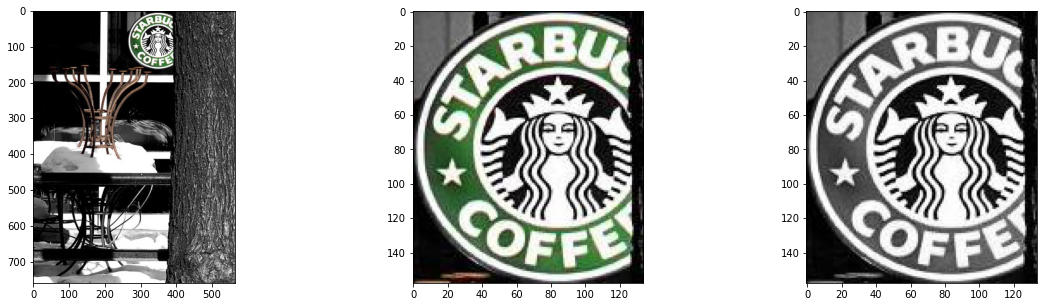

In [5]:
# Visualize one image set of bboxes
im1 = plt.imread(image_dir + '006609.jpg')
bbox1 = plt.imread(preproc_dir + 'data/006609_c.jpg')
bbox2 = plt.imread(preproc_dir + 'data/006609_g.jpg')

# visualize
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(im1)
ax[1].imshow(bbox1)
ax[2].imshow(bbox2)
plt.show()


#### Temp: test new fns

In [6]:
# hu moments
hu_mom = hu_moments(bbox1)
hu_mom

array([[  2.57325701,   6.61785352,  10.38434025,  11.11107106,
         22.04293719, -14.42066926, -21.98016678]])

## TEXTURE

In [7]:
# texture features
gray = bbox2[:, :, 0].copy()

# Find the GLCM
import skimage.feature as feature

In [10]:
# Param:
# source image
# List of pixel pair distance offsets - here 1 in each direction
# List of pixel pair angles in radians
distances = [1, 2]
angles = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2, 5*np.pi/8, 3*np.pi/4, 7*np.pi/8]

graycom = feature.graycomatrix(gray, distances, angles, levels=256)

# Find the GLCM properties
contrast = feature.graycoprops(graycom, 'contrast').reshape(-1)
dissimilarity = feature.graycoprops(graycom, 'dissimilarity')
homogeneity = feature.graycoprops(graycom, 'homogeneity')
energy = feature.graycoprops(graycom, 'energy')
correlation = feature.graycoprops(graycom, 'correlation')
ASM = feature.graycoprops(graycom, 'ASM')

print("Contrast: {}".format(contrast))
print("Dissimilarity: {}".format(dissimilarity))
print("Homogeneity: {}".format(homogeneity))
print("Energy: {}".format(energy))
print("Correlation: {}".format(correlation))
print("ASM: {}".format(ASM))


Contrast: [2949.4665937  2949.4665937  4676.8699296  2542.1490636  2542.1490636
 2542.1490636  4521.33149753 2949.4665937  7204.98609513 8150.13819726
 4676.8699296  7792.34711779 6564.28860505 7484.04569115 4521.33149753
 8013.08820691]
Dissimilarity: [[30.10188446 30.10188446 39.83425123 28.86139367 28.86139367 28.86139367
  39.24701882 30.10188446]
 [51.08678558 56.02200347 39.83425123 54.81087334 49.32343092 53.64748409
  39.24701882 55.26153252]]
Homogeneity: [[0.13069936 0.13069936 0.1040896  0.1328512  0.1328512  0.1328512
  0.10354238 0.13069936]
 [0.09711538 0.09104504 0.1040896  0.09126298 0.09867153 0.09402986
  0.10354238 0.09055447]]
Energy: [[0.02759178 0.02759178 0.02595869 0.02854294 0.02854294 0.02854294
  0.02561457 0.02759178]
 [0.02348514 0.02318295 0.02595869 0.02387587 0.02345259 0.02416128
  0.02561457 0.02383661]]
Correlation: [[0.83852562 0.83852562 0.74376066 0.86096975 0.86096975 0.86096975
  0.7522864  0.83852562]
 [0.60498806 0.55278162 0.74376066 0.5728855

## 2. Feature Extraction (at bbox level)

In [6]:
# Init DF
df = pd.DataFrame({
    'img_file': pd.Series(dtype='str'),
    'bbox_file': pd.Series(dtype='str'),
    'label':  pd.Series(dtype='int'),
    'bbox_num': pd.Series(dtype='int'),
    'simple_feature': pd.Series(dtype='float32'),
    'harris_orb_feature': pd.Series(dtype='float32'),
    'orb_kp_feature': pd.Series(dtype='float32'),
    'harris_sift_feature': pd.Series(dtype='float32'),
    'sift_kp_feature': pd.Series(dtype='float32'),
    })


In [10]:
# Loop through bboxes (rows in bbox_df)
for idx, row in bbox_df.iterrows():
    bbox = plt.imread(preproc_dir + 'data/' + row['bbox_fname'])


    ## FOR EACH BBOX, NEED TO LOAD THE DIFF COLOR SCHEMES AT ASAME TIME


    label = row['class_code']

     # get keypoints and feature descriptors
    harris_kp = HarrisKeypointDetector(bbox, n=2, w=3, k=0.04, p=0.9, verbose=False)
    simple_feature = SimpleFeatureDescriptor(bbox, harris_kp, w=5)
    harris_orb_feature = ORB_SIFT_FeatureDescriptor(bbox, use_orb = True, use_harris=True, nfeatures=10, harris_kp=harris_kp)
    orb_kp_feature = ORB_SIFT_FeatureDescriptor(bbox, use_orb = True, use_harris=False, nfeatures=10, harris_kp=None)
    harris_sift_feature = ORB_SIFT_FeatureDescriptor(bbox, use_orb = False, use_harris=True, nfeatures=10, harris_kp=harris_kp)
    sift_kp_feature = ORB_SIFT_FeatureDescriptor(bbox, use_orb = False, use_harris=False, nfeatures=10, harris_kp=None)

    # get hu, color moments
    hu_mom = hu_moments(bbox)
    # cm_rgb_mean, cm_rgb_var, cm_rgb_skew = extract_color_moments(img_bbox_rgb)
    # cm_hsv_mean, cm_hsv_var, cm_hsv_skew = extract_color_moments(img_bbox_hsv)
    # cm_ycrcb_mean, cm_ycrcb_var, cm_ycrcb_skew = extract_color_moments(img_bbox_ycrcb)
    
    # append to df
    row = {
        'img_file': row['image_source'],
        'bbox_file': row['box_source'],
        'label': label,
        'bbox_num': row['bbox_fname'].split("_")[1],
        'simple_feature': simple_feature,
        'harris_orb_feature': harris_orb_feature,
        'orb_kp_feature': orb_kp_feature,
        'harris_sift_feature': harris_sift_feature,
        'sift_kp_feature': sift_kp_feature,
        'hu_moments': hu_mom,
        # 'cm_rgb_mean': cm_rgb_mean,
        # 'cm_rgb_var': cm_rgb_var,
        # 'cm_rgb_skew': cm_rgb_skew,
        # 'cm_hsv_mean': cm_hsv_mean,
        # 'cm_hsv_var': cm_hsv_var,
        # 'cm_hsv_skew': cm_hsv_skew,
        # 'cm_ycrcb_mean': cm_ycrcb_mean,
        # 'cm_ycrcb_var': cm_ycrcb_var,
        # 'cm_ycrcb_skew': cm_ycrcb_skew,
        }
    df = df.append(row, ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jetcalz07/Desktop/MIDS/W281_CV/logo_detection_w281/data/preprocessed/data/006609_00_bb.jpg'

In [ ]:
# incorporate
class_map= { 0 : 'adidas', 1 : 'dhl', 2 : 'apple', 3 : 'bmw', 4 : 'cocacola', 5 : 'fedex', 6 : 'heineken', 7 : 'pepsi', 8 : 'starbucks', 9 : 'ups'}

In [ ]:
df.to_pickle(base_dir+'data/feature_sets/feature_set_v110922.csv')
test = pd.read_pickle(base_dir+'data/feature_sets/feature_set_v110922.csv')
test.head()